# Load Dataset with Augmented Images, Flatten for Input to MLP

In [ ]:
# ASL Project - Multi-Layer Perceptron Method
# CAP 5610 - Machine Learning
# Michael Miletic (mi542455)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import os
import cv2
import random
import gc

# Path to the ASL Alphabet dataset in local directory
images_path = "archive/asl_alphabet_train/asl_alphabet_train"

# Ensure GPU is being utilized
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Exception handling for if dataset is not found
if not os.path.exists(images_path):
    raise FileNotFoundError(f"Dataset not found at {images_path}")

# Collect the folders for each class
image_folders = os.listdir(images_path)

# Image transformations (grayscale, resizing, normalizing)
IMG_SIZE = (128, 128)
transform_base = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Augmentation of original images (flipping and rotations)
def augmentations(img):
    augmented_images = []
    img_pil = Image.fromarray(img)
    img_tensor = transform_base(img_pil)
    augmented_images.append(img_tensor)  

    # Horizontal flip
    augmented_images.append(transforms.functional.hflip(img_tensor))

    # Random rotations
    for _ in range(2):
        angle = random.uniform(-45, 45)
        augmented_images.append(transforms.functional.rotate(img_tensor, angle))
        augmented_images.append(transforms.functional.rotate(augmented_images[-1], angle))

    return augmented_images

# Class for the ASL Dataset
class ASLDataset(Dataset):
    def __init__(self, images_path, image_folders):
        self.image_paths = []
        self.labels = []
        self.total_samples = 0

        # Iterate through each class folder
        for i, folder in enumerate(image_folders):
            gc.collect()
            folder_path = os.path.join(images_path, folder)
            if not os.path.isdir(folder_path):
                print(f"Skipping {folder}, not a directory")
                continue
            
            # Limit number of images loaded to 1500 per class
            folder_imgs = os.listdir(folder_path)[:1500]
            print(f"Loading {len(folder_imgs)} images from {folder}")

            for img_file in folder_imgs:
                image_path = os.path.join(folder_path, img_file)
                if os.path.isfile(image_path):
                    img = cv2.imread(image_path)
                    if img is None:
                        print(f"Warning: Failed to load {image_path}")
                        continue
                    
                    # Convert image to RGB and resize
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, IMG_SIZE)

                    # Generate 6 augmented images per 1 raw sample
                    augmented_imgs = augmentations(img)

                    # Store each augmented image and its label
                    for aug_img in augmented_imgs:
                        self.image_paths.append(aug_img)
                        self.labels.append(i)

            # Print the total amount of samples loaded after augmentation
            self.total_samples = len(self.image_paths)
            print(f"Total samples after {folder}: {self.total_samples}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = self.image_paths[idx]  
        label = self.labels[idx]
        # Flatten image for MLP input
        flattened_img = img.view(-1)  
        return flattened_img, torch.tensor(label, dtype=torch.int64)

# Load the dataset
dataset = ASLDataset(images_path, image_folders)
# Verify dataset size
print(f"Total dataset size: {len(dataset)}")

# Split dataset (80% Training /20% Testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders and set batch size
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print("Data loading complete. Ready for training!")

Using device: cuda
Loading 1500 images from A
Total samples after A: 9000
Loading 1500 images from B
Total samples after B: 18000
Loading 1500 images from C
Total samples after C: 27000
Loading 1500 images from D
Total samples after D: 36000
Loading 1500 images from E
Total samples after E: 45000
Loading 1500 images from F
Total samples after F: 54000
Loading 1500 images from G
Total samples after G: 63000
Loading 1500 images from H
Total samples after H: 72000
Loading 1500 images from I
Total samples after I: 81000
Loading 1500 images from J
Total samples after J: 90000
Loading 1500 images from K
Total samples after K: 99000
Loading 1500 images from L
Total samples after L: 108000
Loading 1500 images from M
Total samples after M: 117000
Loading 1500 images from N
Total samples after N: 126000
Loading 1500 images from nothing
Total samples after nothing: 135000
Loading 1500 images from O
Total samples after O: 144000
Loading 1500 images from P
Total samples after P: 153000
Loading 1500

# Define Model Architecture and Instantiate Model

In [2]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # Input layer: 128x128 grayscale image flattened to 16384 features
        self.fc1 = nn.Linear(128 * 128, 8192)
        self.bn1 = nn.BatchNorm1d(8192)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        
        # Hidden layer 1: 8192 -> 6144
        self.fc2 = nn.Linear(8192, 6144)
        self.bn2 = nn.BatchNorm1d(6144)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        
        # Hidden layer 2: 6144 -> 4096
        self.fc3 = nn.Linear(6144, 4096)
        self.bn3 = nn.BatchNorm1d(4096)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        
        # Hidden layer 3: 4096 -> 2048
        self.fc4 = nn.Linear(4096, 2048)
        self.bn4 = nn.BatchNorm1d(2048)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)
        
        # Hidden layer 4: 2048 -> 1024
        self.fc5 = nn.Linear(2048, 1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.relu5 = nn.ReLU()
        # Slightly smaller dropout rate for stability
        self.dropout5 = nn.Dropout(0.25)  
        
        # Output layer: 1024 -> 28 classes
        self.fc6 = nn.Linear(1024, 28)

    def forward(self, x):
        # forward pass: Linear -> BN -> ReLU -> Dropout
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.dropout3(self.relu3(self.bn3(self.fc3(x))))
        x = self.dropout4(self.relu4(self.bn4(self.fc4(x))))
        x = self.dropout5(self.relu5(self.bn5(self.fc5(x))))
        x = self.fc6(x)
        return x

# Instantiate the model
model = MLP().to(device)

# Print the model architecture
print(model)

# Define class weights using weighted CE to address class imbalance
class_weights = torch.ones(28).to(device)
class_weights[17] = 3.0 
class_weights[18] = 3.0
class_weights[22] = 5.0
class_weights[23] = 8.0

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0003)  # Adam optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

MLP(
  (fc1): Linear(in_features=16384, out_features=8192, bias=True)
  (bn1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=8192, out_features=6144, bias=True)
  (bn2): BatchNorm1d(6144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=6144, out_features=4096, bias=True)
  (bn3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=4096, out_features=2048, bias=True)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=2048, out_features=1024, bias=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=Tru

# Train Model and Collect Metrics for Evaluation

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    
    # Set model to training mode
    model.train()
    # Initialize list for training accuracies
    training_accuracies = []
    # Initialize list for testing metrics
    testing_metrics = []      
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            if images is None or labels is None:
                continue
                
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate batch accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        training_accuracies.append(epoch_accuracy)
        
        print(f"\nEpoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")
        
        # Evaluation after each epoch
        eval_results = evaluate_model(model, test_loader, criterion)
        testing_metrics.append(eval_results)
        
        print(f"Epoch [{epoch+1}/{epochs}], Test Accuracy: {eval_results['accuracy']:.2f}%, Macro F1: {eval_results['macro_f1']:.4f}")
        
        # Check early stopping condition
        worst_class_accuracy = eval_results['worst_accuracy_class'][1]
        print(f"Worst class accuracy: {worst_class_accuracy:.2f}%")
        
        if worst_class_accuracy >= 95.0:
            print(f"\n{'*'*80}")
            print(f"EARLY STOPPING at epoch {epoch+1}/{epochs}")
            print(f"Worst performing class reached {worst_class_accuracy:.2f}% accuracy")
            print(f"{'*'*80}")
            break
        
        print("-" * 60)
        
        # Clear GPU memory
        torch.cuda.empty_cache()
    
    return training_accuracies, testing_metrics

def evaluate_model(model, test_loader, criterion):
    
    # Set model to evaluation mode
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    # Collect all predictions and targets
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            if images is None or labels is None:
                continue
                
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            # Store predictions and targets for metrics calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Convert to NumPy arrays for metric calculation
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    # Calculate overall accuracy and average loss
    overall_accuracy = 100 * np.mean(all_predictions == all_targets)
    avg_test_loss = test_loss / len(test_loader)
    
    # Calculate macro F1 score (average across every class)
    macro_f1 = f1_score(all_targets, all_predictions, average='macro')
    
    # Calculate per-class metrics
    class_labels = np.unique(all_targets)
    per_class_accuracy = {}
    per_class_f1 = {}
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    
    # Calculate per-class metrics (accuracy and f1-score)
    for class_idx in class_labels:
        class_correct = conf_matrix[class_idx, class_idx]
        class_total = np.sum(all_targets == class_idx)
        class_accuracy = 100 * class_correct / class_total
        per_class_accuracy[int(class_idx)] = class_accuracy
        class_f1 = f1_score(all_targets == class_idx, all_predictions == class_idx, average='binary')
        per_class_f1[int(class_idx)] = class_f1
    
    # Identify best/worst performing classes
    max_acc_class = max(per_class_accuracy.items(), key=lambda x: x[1])
    min_acc_class = min(per_class_accuracy.items(), key=lambda x: x[1])
    max_f1_class = max(per_class_f1.items(), key=lambda x: x[1])
    min_f1_class = min(per_class_f1.items(), key=lambda x: x[1])
    
    # Print evaluation results
    print(f"\n{'='*60}")
    print("TEST EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Overall Test Loss: {avg_test_loss:.4f}")
    print(f"Overall Test Accuracy: {overall_accuracy:.2f}%")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"{'='*60}")
    print("CLASS PERFORMANCE BREAKDOWN")
    print(f"{'='*60}")
    print(f"Best performing class (accuracy): Class {max_acc_class[0]} with {max_acc_class[1]:.2f}% accuracy")
    print(f"Worst performing class (accuracy): Class {min_acc_class[0]} with {min_acc_class[1]:.2f}% accuracy")
    print(f"Best performing class (F1): Class {max_f1_class[0]} with {max_f1_class[1]:.4f} F1 score")
    print(f"Worst performing class (F1): Class {min_f1_class[0]} with {min_f1_class[1]:.4f} F1 score")
    print(f"{'='*60}")
    
    # Return dictionary with all metrics
    evaluation_results = {
        'accuracy': overall_accuracy,
        'loss': avg_test_loss,
        'macro_f1': macro_f1,
        'per_class_accuracy': per_class_accuracy,
        'per_class_f1': per_class_f1,
        'best_accuracy_class': max_acc_class,
        'worst_accuracy_class': min_acc_class,
        'best_f1_class': max_f1_class,
        'worst_f1_class': min_f1_class,
        'confusion_matrix': conf_matrix
    }
    
    return evaluation_results


# call function for training and evaluating
training_accuracies, testing_metrics = train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=20)

# Generate Plots for Evaluation

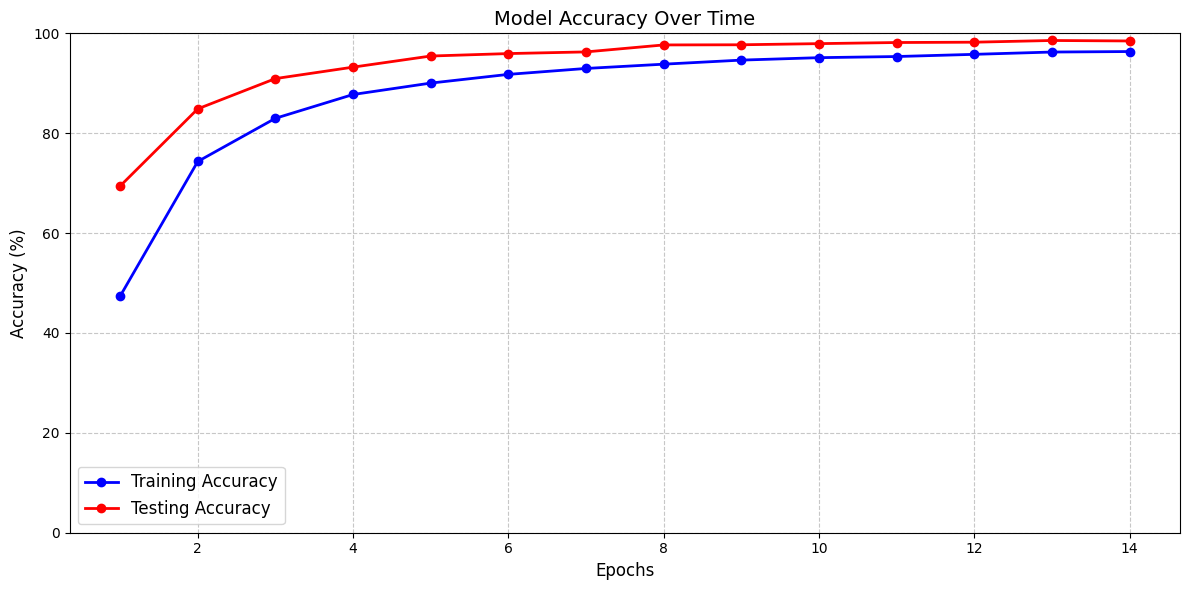

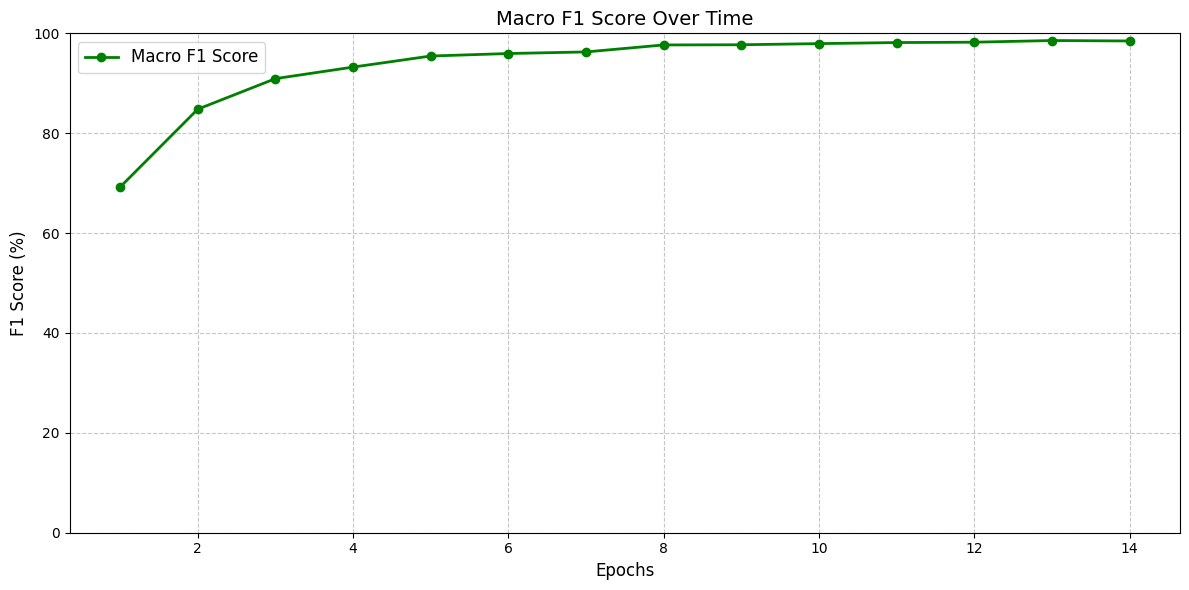

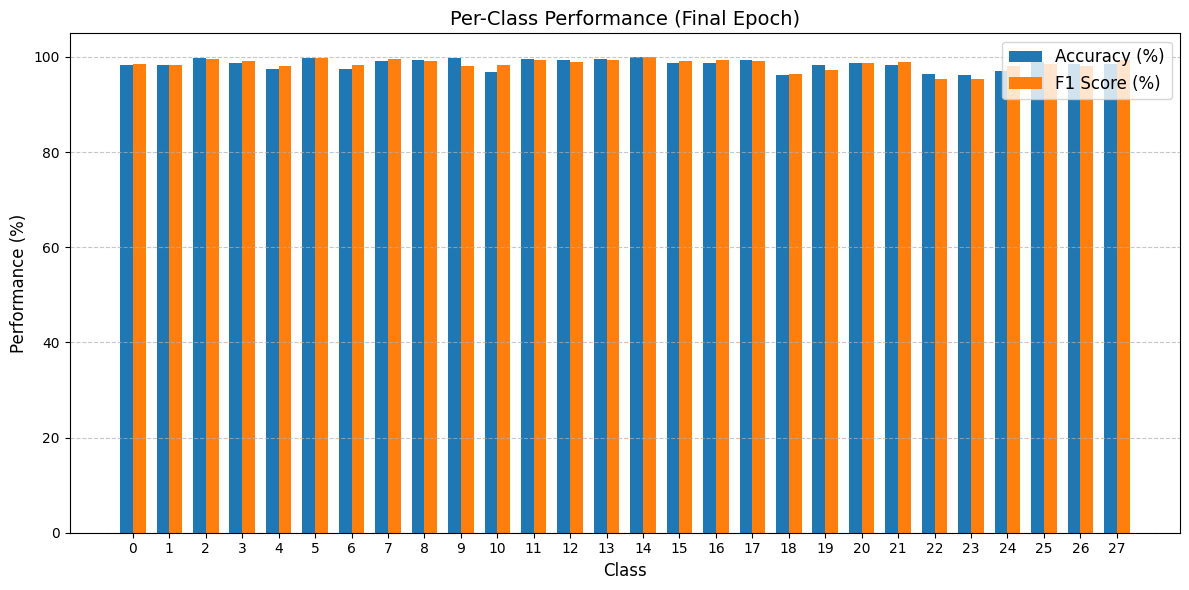

In [ ]:
import matplotlib.pyplot as plt

# Epochs for the x-axis
epochs = range(1, len(training_accuracies) + 1)

# Test accuracy (%) and F1-score (%) over epochs
test_accuracies = [metrics['accuracy'] for metrics in testing_metrics]
# Covert F1 to percentage
test_f1_scores = [metrics['macro_f1'] * 100 for metrics in testing_metrics]

# Plot 1: Training and Testing Accuracy over Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_accuracies, 'b-o', label='Training Accuracy', linewidth=2)
plt.plot(epochs, test_accuracies, 'r-o', label='Testing Accuracy', linewidth=2)
plt.title('Model Accuracy Over Time', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim([0, 100])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 2: Macro F1 Score over Epochs 
plt.figure(figsize=(12, 6))
plt.plot(epochs, test_f1_scores, 'g-o', label='Macro F1 Score', linewidth=2)
plt.title('Macro F1 Score Over Time', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('F1 Score (%)', fontsize=12)
plt.ylim([0, 100])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot 3: Per-class Performance (final epoch)
plt.figure(figsize=(12, 6))
classes = list(testing_metrics[-1]['per_class_accuracy'].keys())
class_accuracies = [testing_metrics[-1]['per_class_accuracy'][c] for c in classes]
# Convert F1 to percentage
class_f1_scores = [testing_metrics[-1]['per_class_f1'][c] * 100 for c in classes]  
x = np.arange(len(classes))
width = 0.35
plt.bar(x - width/2, class_accuracies, width, label='Accuracy (%)')
plt.bar(x + width/2, class_f1_scores, width, label='F1 Score (%)')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Performance (%)', fontsize=12)
plt.title('Per-Class Performance (Final Epoch)', fontsize=14)
plt.xticks(x, classes)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
